<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16 Architecture

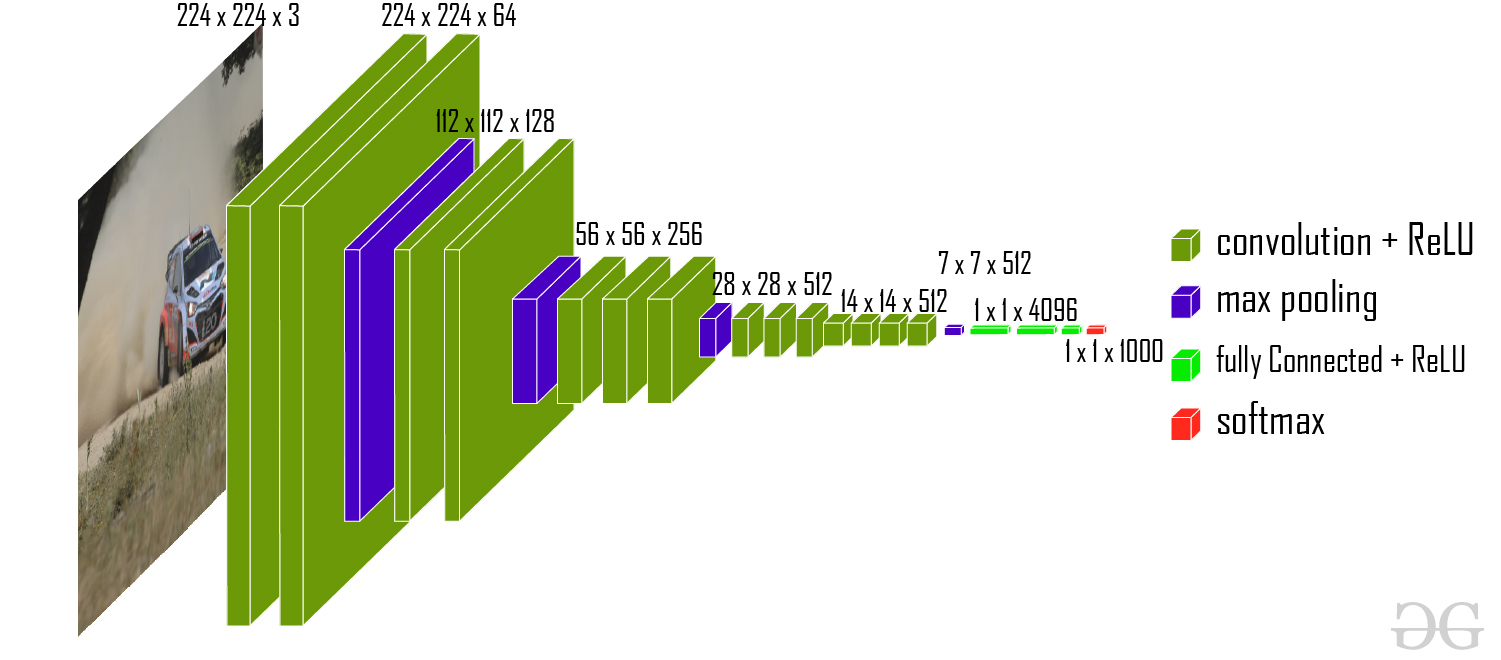

# Code

In [ ]:
from google.colab import drive
import os
import shutil
import json
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
d_or_c_option = "d"
d_or_c_name = "shaunthesheep/microsoft-catsvsdogs-dataset"

os.system("pip install kaggle")

kaggle_key_path = "/content/drive/MyDrive/Kaggle API Key/kaggle.json"
kaggle_key_dest = "/.kaggle"
dataset_path = "/content/data/"

if os.path.exists(dataset_path) is False:
  if d_or_c_option:
    d_or_c = d_or_c_option
  else:
    d_or_c = str.lower(input("Enter D for dataset or C for competition: "))
  if (d_or_c == 'd'):
    if d_or_c_name:
      d_name = d_or_c_name
    else:
      d_name = input("Enter the name of dataset in 'owner/dataset' format: ")
  elif (d_or_c == 'c'):
    if d_or_c_name:
      c_name = d_or_c_name
    else:
      c_name = input("Enter the name of competition in 'owner/competition' format: ")
  else:
    print("Enter valid option!")

if os.path.exists("/content/drive") is False:
  drive.mount('/content/drive')
  print("Drive is ready to use!")
else:
  print("Drive is already ready to use!")

if os.path.exists(os.path.join(kaggle_key_dest, "kaggle.json")) is False:
  os.mkdir(kaggle_key_dest)
  shutil.copy(kaggle_key_path, kaggle_key_dest)
  os.chmod(os.path.join(kaggle_key_dest, "kaggle.json"), 600)
  print("Kaggle api key is ready to use!")
else:
  print("Kaggle api key is already ready to use!")

if os.path.exists(dataset_path) is False:
  with open(os.path.join(kaggle_key_dest, "kaggle.json"), "r") as f:
    data = json.load(f)
  os.environ["KAGGLE_USERNAME"] = data["username"]
  os.environ["KAGGLE_KEY"] = data["key"]
  del data

  import kaggle

  kaggle.api.authenticate()
  if (d_or_c == 'd'):
    kaggle.api.dataset_download_files(
      d_name,
      path=dataset_path,
      unzip=True
    )
    print("Data was downloaded!")
  elif (d_or_c == 'c'):
    kaggle.api.competition_download_files(
        c_name,
        path=dataset_path
    )
    print("Data was downloaded!")
  else:
    print("No data were downloaded!")
else:
  print("Data is already available!")


Drive is already ready to use!
Kaggle api key is ready to use!
Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
Data was downloaded!


In [ ]:
os.listdir("/content/data")

['PetImages', 'MSR-LA - 3467.docx', 'readme[1].txt']

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 100

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
dataset_path = "/content/data/PetImages"

In [ ]:
class ValidImgChooser:
    def __init__(self) -> None:
       self.extensions = ["jpg", "png"]
    def __call__(self, path):
        try:
            im = Image.open(path)
            rgb_im = im.convert('RGB')
            if path.split('.')[-1] not in self.extensions:
                return False
        except Exception as e:
            return False
        return True

In [ ]:
image_transforms = Compose([
    ToTensor(),
    Resize((224, 224))
])

full_data = ImageFolder(
    root=dataset_path,
    transform=image_transforms,
    is_valid_file=ValidImgChooser()
)

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
full_data[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
label_name = {
    0: "cat",
    1: "dog"
}

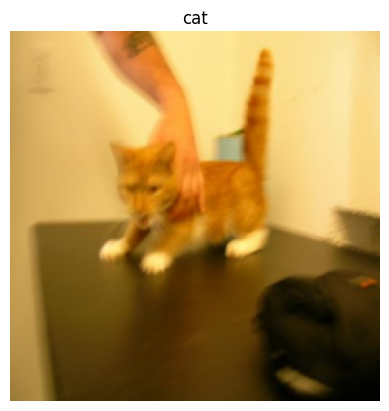

In [ ]:
img, label = full_data[0]
img = img.detach().cpu()
img = img.permute(1, 2, 0).numpy()
plt.imshow((img * 255).astype(np.uint8))
plt.title(label_name[label])
plt.axis(False)
plt.show()

In [ ]:
len(full_data)

24998

In [ ]:
len(full_data) *0.7

17498.6

In [ ]:
train, val, test = random_split(full_data, lengths=[17498, 3750, 3750])
print(len(train), len(val), len(test))

17498 3750 3750


In [ ]:
train_dl = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dl = DataLoader(
    val,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_dl = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(len(train_dl), len(val_dl), len(test_dl))

547 118 118


In [ ]:
class VGG16Net(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), n_ouput_classes=1):
        super(VGG16Net, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape[0],
                out_channels=64,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=512,
                out_channels=512,
                kernel_size=(3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        self.flatten = nn.Flatten()
        self.fc_block = nn.Sequential(
            nn.Linear(in_features=7*7*512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_ouput_classes)
        )


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x

In [ ]:
model = VGG16Net().to(device)
model(torch.randn((1, 3, 224, 224)).to(device)).shape

torch.Size([1, 1])

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
def train(model, dataloader, loss_fn, optimizer):
    dl_len = len(dataloader)
    model.train()

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()

        logits = model(images)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i%100 == 0:
            current = (i + 1) * len(labels)
            print(f"\t[{current}/{dl_len*len(labels)}] Loss: {loss.item():.4f}")
    print(f"Final train loss = {loss.item():.4f}")

In [ ]:
def test(model, dataloader, loss_fn):
    dl_len = len(dataloader)
    ds_len = len(dataloader.dataset)
    cum_loss = 0
    n_correct = 0
    model.eval()

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1).float()

        logits = model(images)
        cum_loss += loss_fn(logits, labels).item()
        preds = logits.argmax(1)
        n_correct += (preds == labels).type(torch.float).sum().item()

    avg_loss = cum_loss / dl_len
    avg_correct = n_correct / (dl_len * ds_len)
    print(f"Test Loss: {avg_loss:.4f} Accuracy: {avg_correct*100:.3f}")

    return avg_loss

In [ ]:
prev_loss = 9999999
saved_weight = None
for i in range(1, N_EPOCHS+1):
    print(f"EPOCH {i} Training...")
    train(model, train_dl, loss_fn, optimizer)
    current_loss = test(model, val_dl, loss_fn)
    if current_loss >= prev_loss:
        print("Training ended")
        break
    prev_loss = current_loss
    saved_weight = model.state_dict()

EPOCH 1 Training...
	[32/17504] Loss: 0.6883
	[3232/17504] Loss: 0.6932
	[6432/17504] Loss: 0.6945
	[9632/17504] Loss: 0.6941
	[12832/17504] Loss: 0.6930
	[16032/17504] Loss: 0.6931
Final train loss = 0.6936
Test Loss: 0.6931 Accuracy: 13.883
EPOCH 2 Training...
	[32/17504] Loss: 0.6928
	[3232/17504] Loss: 0.6935
	[6432/17504] Loss: 0.6909
	[9632/17504] Loss: 0.6928
	[12832/17504] Loss: 0.6932


KeyboardInterrupt: 

In [ ]:
model.load_state_dict(saved_weight)

In [ ]:
test(model, test_dl, loss_fn)